In [ ]:
!pip install qutip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 98.9 MB/s eta 0:00:00


In [ ]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [ ]:
def sigma_composite(N):
  #Se construyen los operadores sigma para el espacio compuesto de N qubits
  sx_list, sy_list, sz_list = [], [], []
  sm_list, sp_list= [], []
  for i in range(N):
    op_list = [qeye(2)] * N
    op_list[i] = sigmax()
    sx_list.append(tensor(op_list))
    op_list[i] = sigmay()
    sy_list.append(tensor(op_list))
    op_list[i] = sigmaz()
    sz_list.append(tensor(op_list))
    op_list[i] = sigmam()
    sm_list.append(tensor(op_list))
    op_list[i] = sigmap()
    sp_list.append(tensor(op_list))
  return (sx_list, sy_list, sz_list, sm_list, sp_list)


In [ ]:

def quantum_hamiltonian():
  # Estado Inicial de Máxima Coherencia
  state_list = [(1/np.sqrt(2))*(basis(2, 0) + basis(2, 1))]*N
  state = tensor(state_list)
  ep = np.ones(N)

  #Hamiltoniano interno del sistema
  H0 = 0
  for k in range(N):
    H0 += ep[k]*sp_list[k]*sm_list[k]
  H0t = [H0 for step  in range(steps)]

  #Hamiltoniano de Interacción
  Hint = 0
  if N != 1:
      for i in range(N):
        if i == 0:
          Hint += J*(sp_list[i]*sm_list[i+1])
        elif i == N-1:
          Hint += J*(sp_list[i]*sm_list[i-1])
        else:
          Hint += J*(sp_list[i]*sm_list[i-1])
          Hint += J*(sp_list[i]*sm_list[i+1])

  H = H0 + Hint
  return(H, state, H0t,state_list)

In [ ]:
#Ecuación maestra en el espacio de Liouville (Operador Liouvilliano)
def me_liouvillian(t: float, args: dict):
  out = Li.copy()
  for i in range(N):
    for j in range(N):
      if i==j:
        out += gamma*lindblad_dissipator(a=sm_list[j],b=sm_list[i])
  if N!=1:
      for i in range(N):
        if i == 0:
          out += gamma_i*lindblad_dissipator(sm_list[i],sm_list[i+1])
        elif i == N-1:
          out += gamma_i*lindblad_dissipator(sm_list[i],sm_list[i-1])
        else:
          out += gamma_i*lindblad_dissipator(sm_list[i],sm_list[i-1])
          out += gamma_i*lindblad_dissipator(sm_list[i],sm_list[i+1])
  return out

In [ ]:
def eigen_system():
  M_val = []
  M_vec = []
  H_val = []
  H_vec = []

  for n in range(len(Hci[2])):
      qobjH = Qobj(Hci[2][n])
      qobjM = Qobj(DensityM[n])

      # AUTOVECTORES
      e_statesH = qobjH.eigenstates()
      e_statesM = qobjM.eigenstates(sort='high')

      # AUTOVALORES
      autovals_H = e_statesH[0]
      autovals_M = e_statesM[0]

      H_val.append(autovals_H)
      M_val.append(autovals_M)


      autovec_H = e_statesH[1]
      H_vec.append(autovec_H)
      autovec_M = e_statesM[1]
      M_vec.append(autovec_M)

  return(M_val, M_vec, H_val, H_vec)

\begin{align}
    \mathcal{W}(t) = \sum_{i,j}^{2} \rho_{i} \varepsilon_{j} \left(|\langle{\rho_{i}} |{\varepsilon_{j}}\rangle|^{2} -\delta_{ij} \right).
\end{align}

In [ ]:
def ergotropy():
  Erg = []
  Ut= []
  Ergo_t = 0
  i,j,k = 0,0,0
  for i in range(len(t)):
    for j in range(len(M_val[0])):
      for k in range(len(H_val[0])):
        if j==k:
          Ergo_t = Ergo_t + M_val[i][j]*H_val[i][k]*((((M_vec[i][j].dag())*(H_vec[i][k])).norm())**2-1)
        else:
          Ergo_t = Ergo_t + M_val[i][j]*H_val[i][k]*((((M_vec[i][j].dag())*(H_vec[i][k])).norm())**2)
    Erg.append(Ergo_t)
    Ergo_t = 0

    #Energía interna
    E = np.dot(DensityM[i],Hci[2][i])
    U = np.trace(E)
    Ut.append(U)

  return(Erg, Ut)

In [ ]:
def efficiency(qubits = None):
  Eff = np.divide(Erg,Ut)
  return Eff

\begin{align}
    \mathcal{C}_{l_{1}}(t) = \frac{1}{\mathcal{C}_{\max}}\sum_{i\neq j}|\rho_{ij}(t)|.
\end{align}

In [ ]:
def coherence():
  coherence = []
  count,cohe = 0,0
  for n in range(len(t)):
    for i in range(len(DensityM[0][:])):
      for j in range(len(DensityM[0][:])):
        if i!=j:
          count +=1
          cohe += abs(DensityM[n][i,j])
    coherence.append(cohe)
    cohe = 0


  return coherence

\begin{align}
        E(t) = \frac{1}{\mathcal{N}_{\{i,j\}}}\sum_{\{i,j\}}\mathcal{C}_{i  j}(t)
\end{align}

In [ ]:
def concurrence_t():
  Ctotal = []

  cte = 1/(N-1)

  for n in range(len(t)):
    Csum = 0
    for i in range(N-1):
      Csum += concurrence(DensityM[n].ptrace([i,i+1]))
    Ctotal.append(Csum)

  return np.multiply(cte,Ctotal)

In [ ]:
#Calculo para un número N fijo
N = int(input("Number of Qubits: "))
gamma = float(input("Gamma: "))
steps = 3500
t = np.linspace(0, 250, steps)

gamma_i = gamma/2
ep = 1
J = 2 * gamma
sx_list, sy_list, sz_list, sm_list, sp_list = sigma_composite(N)

Hci = quantum_hamiltonian()
Li = liouvillian(Hci[0],[])
DensityM = qutip.mesolve(me_liouvillian, Hci[1], t).states



Number of Qubits: 4
Gamma: 0.1


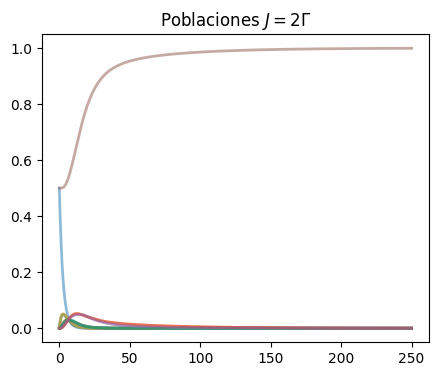

In [ ]:
fig , ax = plt.subplots(figsize=(5,4))
ax.set_title(r'Poblaciones $J=2\Gamma$ ',fontsize = 12 )

for n in range(len(DensityM[0][:])):
  val = str(n+1) * 2
  ax.plot(t, np.real(np.array(DensityM)[:, n, n]),linewidth=2, label= fr'$\rho_{{{val}}}(t)$', alpha= 0.5)

In [ ]:
M_val, M_vec, H_val, H_vec = eigen_system()
Erg, Ut = ergotropy()

(0.0, 50.0)

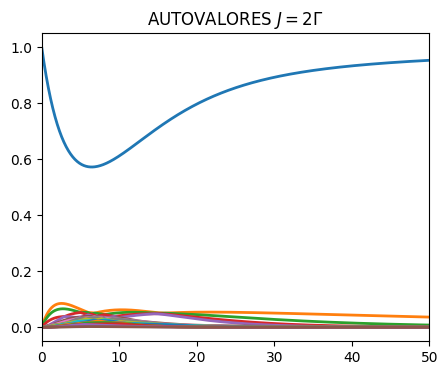

In [ ]:
#Gráficas de autovalores de la matriz densidad
fig , ax = plt.subplots(figsize=(5,4))
ax.set_title(r'AUTOVALORES $J=2\Gamma$ ',fontsize = 12 )

for i in range(len(M_val[0])):
  variable = str(i+1) + "-" + str(i+1)
  ax.plot(t, [np.real(lista[i]) for lista in M_val],linewidth=2, label= fr'$\rho_{{{variable}}}(t)$')
    #ax.legend()
ax.set_xlim(0,50)

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 0, '$\\Gamma t$')

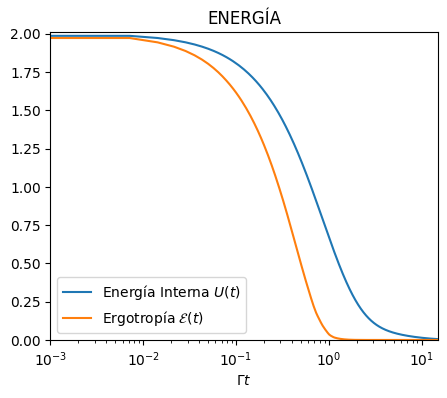

In [ ]:
fig, ax = plt.subplots(figsize=(5,4))
ax.set_title('ENERGÍA',fontsize = 12 )
ax.plot(gamma*t,Ut,label=r"Energía Interna ${U}(t)$")
ax.plot(gamma*t,Erg,label=r"Ergotropía $\mathcal{E}(t)$")
ax.set_xscale('log')
ax.legend()
ax.set_xlabel(r"$\Gamma t$")


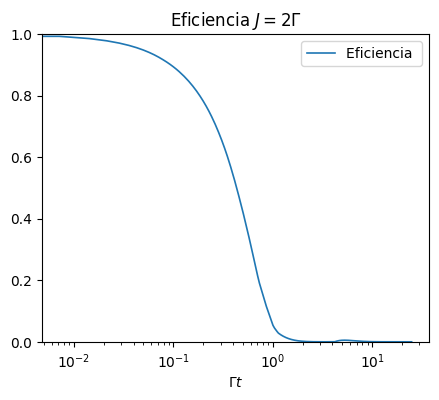

In [ ]:
Eff = efficiency()
fig, ax = plt.subplots(figsize=(5,4))
ax.set_title('Eficiencia $J=2\Gamma$',fontsize = 12 )
ax.plot(gamma*t,Eff,label=f"Eficiencia ")
ax.set_xscale('log')
ax.set_xlabel(r"$\Gamma t$")
ax.legend()

In [ ]:
Coherence_t = coherence()

(-0.001, 1.5)

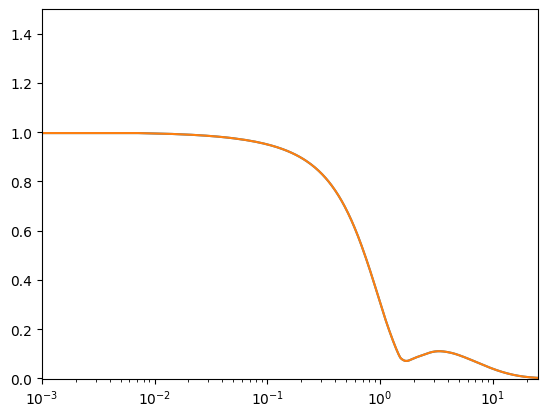

In [ ]:
fig, ax = plt.subplots()
ax.plot(gamma*t,np.multiply(1/max(Coherence_t),Coherence_t))
ax.set_xscale('log')

(0.001, 10)

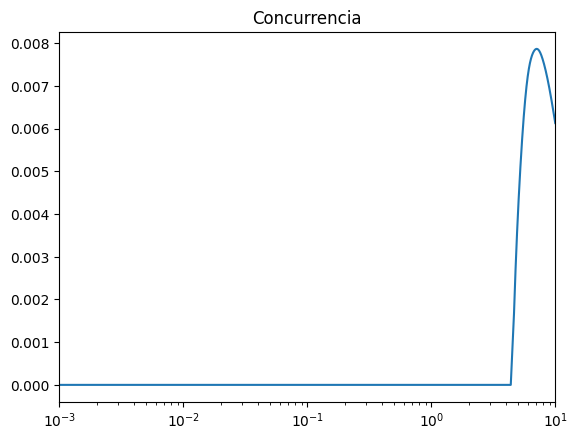

In [ ]:
concurrencia_t = concurrence_t()
fig, ax = plt.subplots()
ax.plot(gamma*t,concurrencia_t)
ax.set_title('Concurrencia')
ax.set_xscale('log')

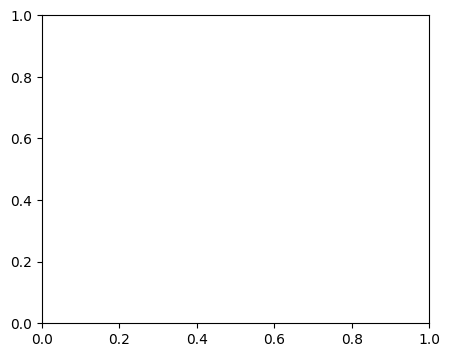

In [ ]:
# Escalamiento de N=1 a N=5 para cadena de Espín

fig , ax = plt.subplots(figsize=(5,4))
Nqubits = []
for i in range(1,6):
  N = i
  sx_list, sy_list, sz_list, sm_list, sp_list = sigma_composite(N)
  Hci = quantum_hamiltonian()
  Li = liouvillian(Hci[0],[])
  DensityM = qutip.mesolve(me_liouvillian, Hci[1], t).states
  M_val, M_vec, H_val, H_vec = eigen_system()
  Erg, Ut = ergotropy()
  Eff = efficiency()
  dic = {
      "Ut": Ut,
      "Ergo": Erg,
      "Eff": Eff
  }
  Nqubits.append(dic)
